# Digits classifier

Let's build a model that is able to recognize a single digit from 0 to 9 from an image.

In [1]:
# loading and setting up dependencies
import fastbook

fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
from matplotlib import pyplot as plt
from torch.nn import functional as F

In [7]:
# checking that we"re using GPU for this one
torch.cuda.get_device_name()

RuntimeError: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

## Importing the dataset

In [2]:
# import MNIST dataset
path_to_mnist = untar_data(URLs.MNIST)
Path.BASE_PATH = path_to_mnist

path_to_mnist.ls()

(#2) [Path('testing'),Path('training')]

As you can see from the previous output, this dataset is organized into separate folders for testing and training sets.

In [3]:
# let's see what's in the training set
(path_to_mnist / 'training').ls(), (path_to_mnist / 'training/1').ls()

((#10) [Path('training/9'),Path('training/1'),Path('training/2'),Path('training/6'),Path('training/3'),Path('training/5'),Path('training/8'),Path('training/4'),Path('training/7'),Path('training/0')],
 (#6742) [Path('training/1/24904.png'),Path('training/1/32446.png'),Path('training/1/15068.png'),Path('training/1/36030.png'),Path('training/1/9628.png'),Path('training/1/1242.png'),Path('training/1/50292.png'),Path('training/1/35908.png'),Path('training/1/18393.png'),Path('training/1/57761.png')...])

In [4]:
# now let's see what's in the testing set
(path_to_mnist / 'testing').ls(), (path_to_mnist / 'testing/1').ls()

((#10) [Path('testing/9'),Path('testing/1'),Path('testing/2'),Path('testing/6'),Path('testing/3'),Path('testing/5'),Path('testing/8'),Path('testing/4'),Path('testing/7'),Path('testing/0')],
 (#1135) [Path('testing/1/6527.png'),Path('testing/1/6239.png'),Path('testing/1/1548.png'),Path('testing/1/2529.png'),Path('testing/1/6917.png'),Path('testing/1/9760.png'),Path('testing/1/8586.png'),Path('testing/1/4273.png'),Path('testing/1/2982.png'),Path('testing/1/2674.png')...])

Let's save the paths to all training digits in a list, and all testing digits in another list.

In [5]:
mnist_training_0s = (path_to_mnist / 'training' / '0').ls().sorted()
mnist_training_1s = (path_to_mnist / 'training' / '1').ls().sorted()
mnist_training_2s = (path_to_mnist / 'training' / '2').ls().sorted()
mnist_training_3s = (path_to_mnist / 'training' / '3').ls().sorted()
mnist_training_4s = (path_to_mnist / 'training' / '4').ls().sorted()
mnist_training_5s = (path_to_mnist / 'training' / '5').ls().sorted()
mnist_training_6s = (path_to_mnist / 'training' / '6').ls().sorted()
mnist_training_7s = (path_to_mnist / 'training' / '7').ls().sorted()
mnist_training_8s = (path_to_mnist / 'training' / '8').ls().sorted()
mnist_training_9s = (path_to_mnist / 'training' / '9').ls().sorted()

mnist_testing_0s = (path_to_mnist / 'testing' / '0').ls().sorted()
mnist_testing_1s = (path_to_mnist / 'testing' / '1').ls().sorted()
mnist_testing_2s = (path_to_mnist / 'testing' / '2').ls().sorted()
mnist_testing_3s = (path_to_mnist / 'testing' / '3').ls().sorted()
mnist_testing_4s = (path_to_mnist / 'testing' / '4').ls().sorted()
mnist_testing_5s = (path_to_mnist / 'testing' / '5').ls().sorted()
mnist_testing_6s = (path_to_mnist / 'testing' / '6').ls().sorted()
mnist_testing_7s = (path_to_mnist / 'testing' / '7').ls().sorted()
mnist_testing_8s = (path_to_mnist / 'testing' / '8').ls().sorted()
mnist_testing_9s = (path_to_mnist / 'testing' / '9').ls().sorted()

## Using a linear model with SGD to classify digits

In this approach, we will need a kind of weight assignmen and a way of improving our classifier based on testing the effectiveness of this assignment.

_Stochastic gradient descent_ is a technique used to update the weights of a neural network in order to make it improve at any given task. Its power resides in the fact that it provides a way of finding weight values automatically.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one.

For instance, pixels toward the bottom right are not very likely to activate neurons for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. 

This can be represented as a function with a set of weight values for each possible category, for instance the probability of being the number 8 =>

```python
def pr_eight(image_vector, weights_vector): return (image_vector * weights_vector).sum()
```

Here, the image represented as a vector is basically "all the rows stacked up end to end on a single long line". With this kind of function, we just need some way to update the weights to make them better and better at distinguishing between digits: we want to find the specific values for the weights that cause the result of our function to be high for images that are actually 8s, and low for images that are not. Searching for the best weights is a way of searching for the best function that recognizes 8s.

These are the steps that will turn our function into a machine learning classifier:

1. _initialize_ the weights with random values
2. for each image, use these weights to predict whether it appears to be a given digit
3. based on these predictions, calculate how good the model is (its _loss_)
4. calculate the _gradient_, which measures for each weight, how changing that weight would change the loss; the gradients will tell us how much we have to change each weight to make our model better
5. _step_ (that is, _change_) all the weights based on the previous calculation
6. go back to step 2 and repeat the process
7. iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer). Generally, you would want to stop the training process when the model stops improving or gets worse

These relatively simple steps are the basis for nearly all deep learning models.

When we know how a function changes, we know what we need to make its value smaller. This is what weights assignment is all about.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative of these weights we won't get back one number, but rather lots of them: a _gradient_ for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

Thankfully, `PyTorch` can automatically compute the derivative of nearly any function!
Adjusting the weights of our model can be then expressed as simply as:

```python	
weights -= gradient * lr
```

This is what _stepping the weights_ actually means.

We use a substraction here to allow for:

- in case the slope is positive, the weight to be decreased
- in case the slope is negative, the weight to be increased

Remember: our ultimate goal is to minimize the loss.

Let's summarize a few points here:

- The weights of a model can be random (training a model from scratch) or they can come from a pre trained model (transfer learning).
- If you train a model from scratch, the first outputs you'll get will probably be pretty bad, because your weights are random.
- Also, in case of a pretrained model, the first outputs won't probably be what you want, because the model was trained for a different task. So, the model will need to _learn_ better weights.
- To measure the performance of a model, you compare the outputs the model gives you with the targets (the true labels), using a loss function.
- We want the output of the loss function to be as low as possible by improving the weights of the model.
- For improving the model, you'd want to set aside a few data items that you don't train the model on, called the _validation set_. This is the set that will be used to measure performance.
- Figuring out how to change the loss to make it better heavily relies on Calculus and gradients. This is made easy with tools like `PyTorch` 😎.
- At each pass of the iterative process that makes the weights better, we use the magnitude of each gradient to tell us how big a step is to take into a better direction. We multiply the gradients by a number called the _learning rate_ to decide each step size.
- When the loss does not get any better, we say that the model has _converged_ and we stop the training.

Alright, we are ready to apply this to the MNIST dataset now !



## Defining training and validation sets + parameters

In [6]:
# create lists of tensors containing all digits (one for every digit)
list_0s = [tensor(Image.open(digit)) for digit in mnist_training_0s]
list_1s = [tensor(Image.open(digit)) for digit in mnist_training_1s]
list_2s = [tensor(Image.open(digit)) for digit in mnist_training_2s]
list_3s = [tensor(Image.open(digit)) for digit in mnist_training_3s]
list_4s = [tensor(Image.open(digit)) for digit in mnist_training_4s]
list_5s = [tensor(Image.open(digit)) for digit in mnist_training_5s]
list_6s = [tensor(Image.open(digit)) for digit in mnist_training_6s]
list_7s = [tensor(Image.open(digit)) for digit in mnist_training_7s]
list_8s = [tensor(Image.open(digit)) for digit in mnist_training_8s]
list_9s = [tensor(Image.open(digit)) for digit in mnist_training_9s]

list_0s_test = [tensor(Image.open(digit)) for digit in mnist_testing_0s]
list_1s_test = [tensor(Image.open(digit)) for digit in mnist_testing_1s]
list_2s_test = [tensor(Image.open(digit)) for digit in mnist_testing_2s]
list_3s_test = [tensor(Image.open(digit)) for digit in mnist_testing_3s]
list_4s_test = [tensor(Image.open(digit)) for digit in mnist_testing_4s]
list_5s_test = [tensor(Image.open(digit)) for digit in mnist_testing_5s]
list_6s_test = [tensor(Image.open(digit)) for digit in mnist_testing_6s]
list_7s_test = [tensor(Image.open(digit)) for digit in mnist_testing_7s]
list_8s_test = [tensor(Image.open(digit)) for digit in mnist_testing_8s]
list_9s_test = [tensor(Image.open(digit)) for digit in mnist_testing_9s]

# let's stack our images and cast our stacked tensors as float tensors for further computation,
# we also normalise our pixel values to be between 0 and 1 by dividing by 255, this will improve our model's accuracy
stacked_0s = torch.stack(list_0s).float()/255
stacked_1s = torch.stack(list_1s).float()/255
stacked_2s = torch.stack(list_2s).float()/255
stacked_3s = torch.stack(list_3s).float()/255
stacked_4s = torch.stack(list_4s).float()/255
stacked_5s = torch.stack(list_5s).float()/255
stacked_6s = torch.stack(list_6s).float()/255
stacked_7s = torch.stack(list_7s).float()/255
stacked_8s = torch.stack(list_8s).float()/255
stacked_9s = torch.stack(list_9s).float()/255
# a _shape_ tells us the length of each axis of a tensor
stacked_3s.shape # the output says "we have 6131 images, each of size 28x28 pixels".

torch.Size([6131, 28, 28])

For our digits classifier issue to solve, we already have independent variables (x-axis): these are the images themselves. This means we can put together our training dataset.

Let's concatenate all of them into a single tensor.

To do this, we'll need to go from a rank-3 tensor of images stacked together to a list of vectors (rank-2 tensor). This can be done using the `view` method of `PyTorch` tensors, as it changes the shape of a tensor without changing its contents.

In [55]:
# `torch.cat` concatenates tensors along the first dimension;
# then `view` reshapes the concatenated tensor into a rank-2 tensor,
# this new tensor has 28*28 columns and a number of rows equal to the number of images in the concatenated tensors;
# a 28*28 image is flattened into a 784 pixels vector
train_x = torch.cat([stacked_0s, stacked_1s, stacked_2s, stacked_3s, 
    stacked_4s, stacked_5s, stacked_6s, stacked_7s, 
    stacked_8s, stacked_9s]).view(-1, 28*28)

In [53]:
# let's label each image
train_y = tensor([1]*len(mnist_threes) + [0]*len(mnist_sevens)).unsqueeze(1)

The line of code above:

- concatenates 2 tensors of length `len(threes)` and `len(sevens)` respectively
- the first elements of this new tensor (`len(threes)`) are set to 0
- the last elements of this new tensor (`len(sevens)`) are set to 1
- calling `unsqueeze` on a tensor adds an extra dimension to it
- we add one extra dimension to match the shape of the images tensor that will be fed to the model
- the resulting tensor has a shape of `(n, 1)`, where `n` is the number of images in the dataset

In [56]:
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in `PyTorch` is an abstract class that represents a collection of data samples.

When indexed, a `Dataset` is required to return a tuple of `(x,y)`, where `x` is the input data and `y` is the label.

Let's create our `Dataset` of images and labels using the `zip` function:

In [57]:
training_set = list(zip(train_x,train_y))

# taking a look at the first element of the dataset,
# here, `y` represents the label of the image
x,y = training_set[0] 
x.shape,y

(torch.Size([784]), tensor([1]))

In [58]:
# now, let's put together our validation set
valid_x = torch.cat([mnist_validation_threes, mnist_validation_sevens]).view(-1, 28*28)
valid_y = tensor([1]*len(mnist_validation_threes) + [0]*len(mnist_validation_sevens)).unsqueeze(1)
validation_set = list(zip(valid_x,valid_y))

In [59]:
# let's initialize our weights for every pixel with random values

# this function returns a tensor of size `size` filled with random values from a normal distribution with a standard deviation of `std`
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
# print a sample of our weights
weights[:5]

tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784]], grad_fn=<SliceBackward0>)

If the goal is to multiply each pixel of the images by a weight value, we should take into account the fact that some pixels will have a value of `0`.

This means that the function `weights * pixels` won't be flexible enough for our purpose since it can sometimes result in a value of `0` even if the weight is not `0`. That's not we want.

Now, since the equation of a straight line is `y = wx + b`, we can add a constant `b` to our function to make it more flexible. This is called a _bias_.

Together, the _weights_ and the _bias_ are called the _parameters_ of the model.

In [60]:
bias = init_params(1)
bias

tensor([0.3472], requires_grad=True)

In [1051]:
# we are now able to calculate a prediction for an image,
# this is a simple implementation of a linear regression model;
# `weights.T` means "taking the transpose of the weights tensor",
# this is done because we want to multiply the weights by the pixels of the image,
# so we turn the `weights` matrix rows into columns and vice versa
(train_x[0]*weights.T).sum() + bias

tensor([8.3031], grad_fn=<AddBackward0>)

While we could use a Python for loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix: matrix multiplication.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [1052]:
weights.shape

torch.Size([784, 1])

In [1053]:
train_x.shape

torch.Size([12396, 784])

In [64]:
def multiply_data_by_params_model(independent_variables): return independent_variables@weights + bias
preds = multiply_data_by_params_model(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

The equation `batch @ weights + bias` is a fundamental equation of any neural network.

## checking our model's accuracy

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, since a 3 is a one and a 7 is a 0, so our accuracy for each item can be calculated (using broadcasting and no loops!) with:

In [65]:

corrects = (preds > 0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [66]:
# our accuracy would be ...
corrects.float().mean().item()

0.5379961133003235

## Choosing a loss function

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some loss function that represents how good our model is. That is because the gradients are a measure of how the loss function changes with small tweaks to the weights. So, we need to choose a loss function.

A very small change of a weight won't influence the overall accuracy of the model, so we can exclude accuracy as our loss function.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `predictions`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another parameter, `targets`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

Let's try this:

In [67]:
# measure how distant each prediction is from 1 if it should be 1, 
# and how distant it is from 0 if it should be 0, 
# and then take the mean of all those distances

def mnist_loss(predictions, targets):
    # The 'torch.where' function takes three arguments: condition, x, and y.
    # It returns a new tensor where each element comes from either 'x' or 'y', depending on the corresponding element in 'condition'.
    return torch.where(
        targets == 1,  # Condition: Check where the targets are 1
        1 - predictions,  # x: If target is 1, loss is (1 - prediction)
        predictions  # y: If target is 0, loss is (prediction)
    ).mean()  # Calculate the mean of the resulting tensor


`torch.where(condition, x, y)` is a PyTorch function that takes a condition and two tensors x and y. For each element in the condition tensor, it will choose the corresponding element from x if the condition is True, and from y if the condition is False.

The function above will return a lower number when:

- predictions are more accurate
- accurate predictions are more confident
- inaccurate predictions are less confident

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that: the _sigmoid_ function.

In [69]:
# let's update the `mnist_loss` function to use the sigmoid function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Putting our linear modal together

In [71]:
# initialize our parameters
weights = init_params((28*28,1))
bias = init_params(1)

# creating a data loader that will return batches of a given size shuffled for every epoch
training_data_loader = DataLoader(training_set, batch_size=256)
x,y = first(training_data_loader)
x.shape,y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [77]:
# creating a data loader for the validation set
validation_data_loader = DataLoader(validation_set, batch_size=256)

In [76]:
# let's define a few functions that will help us calculate the gradients and update the weights and biases

# let's also write a function that calculates accuracy for each batch
def batch_accuracy(independent_variables, dependent_variables):
    preds = independent_variables.sigmoid()
    correct = (preds > 0.5) == dependent_variables
    return correct.float().mean()

# let's put this logic into a function for:
#  - making predictions
#  - calculating the loss
#  - calculating the gradients
def calc_grad(independent_variables, dependent_variables, model):
    preds = model(independent_variables)
    loss = mnist_loss(preds, dependent_variables)
    # The `backward` function actually adds the gradients of `loss` to any gradients that are currently stored.
    loss.backward()

# we need to update the weights and biases based on the gradient and learning rate
def train_epoch(model, lr, params):
    for x, y in training_data_loader:
        calc_grad(x, y, model)
        for p in params:
            p.data -= p.grad*lr
            # we have to tell `PyTorch` to not store the gradients for this step,
            # otherwise they would accumulate and things could get very confusing
            p.grad.zero_()

# let's write a validation function,
# this function `validate_epoch` takes a PyTorch model as input and evaluates its accuracy on a validation dataset.
# It does so by iterating over batches of data in the validation dataloader, 
# passing each batch through the model to get the predicted outputs, 
# and comparing those predictions to the true labels (`dependent_variables`) to calculate the accuracy of each batch. 
# The function then returns the average accuracy across all batches, rounded to 4 decimal places.
def validate_epoch(model):
    accs = [batch_accuracy(model(independent_variables), dependent_variables) for independent_variables, dependent_variables in validation_data_loader]
    return round(torch.stack(accs).mean().item(), 4)

In [78]:
# let's run a first iteration of our model
lr = 1.
params = weights, bias
train_epoch(multiply_data_by_params_model, lr, params)
validate_epoch(multiply_data_by_params_model)

0.6546

In [79]:
# then let's do a few more rounds
for i in range(10):
    train_epoch(multiply_data_by_params_model, lr, params)
    print(validate_epoch(multiply_data_by_params_model), end=' ')

0.8158 0.8915 0.9291 0.9413 0.9486 0.953 0.956 0.9574 0.9589 0.9599 

... this is pretty promising !

Now let's create an object that will handle the SGD steps for us. In `PyTorch`, it's called an _optimizer_.

There is a module in `PyTorch` called `nn.Linear`: it does the same things as `init_params` and `multiply_data_by_params_model` together.

It will contain both the weights and the biases of our model in a single class.

In [80]:
linear_model = nn.Linear(28*28,1)

weights, biases = linear_model.parameters()
weights.shape, biases.shape

(torch.Size([1, 784]), torch.Size([1]))

In [81]:
# let's use that to create our basic optimizer
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

# let's make an instance of it using our model's parameters
opt = BasicOptim(linear_model.parameters(), lr)   

# this simplifies our training loop to:
def train_epoch(model):
    for x, y in training_data_loader:
        calc_grad(x, y, model)
        opt.step()
        opt.zero_grad()

# we can now write a function that trains our model:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [82]:
# let's try it out
train_model(linear_model, 20)

0.4932 0.8262 0.8408 0.9126 0.9341 0.9468 0.9555 0.9629 0.9653 0.9668 0.9692 0.9717 0.9731 0.9751 0.9761 0.9765 0.9775 0.9785 0.9785 0.9785 

What we have just did with `BasicOptim` is implemented in `fastai` with the `SGD` class.

In [83]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.749 0.8579 0.917 0.9365 0.9521 0.957 0.9629 0.9658 0.9687 0.9707 0.9721 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.978 0.978 

Also, the implementation of our `train_model` function in `fastai` is called `Learner.fit`

In [84]:
dls = DataLoaders(training_data_loader, validation_data_loader)

We are about to create a `Learner` without using an application such as `vision_learner`. For this, we can pass in all the elements that we've created: 

- any metrics we want to use (accuracy in this case)
- the data loaders
- the loss function
- the model
- the optimization function, which will be passed the parameters

In [86]:
learner = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

# now we can call `fit` to train our model across multiple epochs
learner.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636516,0.503599,0.495584,00:00
1,0.567307,0.194196,0.835623,00:00
2,0.207229,0.181414,0.835132,00:00
3,0.089765,0.106924,0.910206,00:00
4,0.046562,0.078032,0.932777,00:00
5,0.029760,0.062546,0.947007,00:00
6,0.022909,0.052922,0.955839,00:00
7,0.019906,0.046520,0.961236,00:00
8,0.018408,0.042010,0.965162,00:00
9,0.017523,0.038679,0.967125,00:00


## Writing our own neural network

Let's try to write a very basic neural network:

In [87]:
# an illustration of the universal approximation theorem
def simple_net(independent_variables): 
    res = independent_variables@w1 + b1
    # here we have our relu activation function
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

# let's use this
# here `w1` is the weights matrix connecting the input layer to a layer of 30 neurons (the hidden layer)
w1 = init_params((28*28,30))
b1 = init_params(30)
# here `w2` is the weights matrix connecting the hidden layer to the output layer, which has a single neuron (since we're just trying to predict one number, 3 or 7)
w2 = init_params((30,1))
b2 = init_params(1)

In the above example, the first hidden layer can construct 30 different features, each representing some different mix of pixels. Changing the value `30` will result in a more or less complex model.

In [88]:
# `PyTorch` version of our simple neural network
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
    loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.334446,0.408529,0.505397,00:00
1,0.154280,0.237300,0.792444,00:00
2,0.084378,0.118382,0.910697,00:00
3,0.054719,0.079430,0.939647,00:00
4,0.041056,0.061905,0.956330,00:00
5,0.034140,0.052130,0.963199,00:00
6,0.030212,0.045985,0.964181,00:00
7,0.027690,0.041786,0.966143,00:00
8,0.025886,0.038731,0.968106,00:00
9,0.024494,0.036397,0.969087,00:00


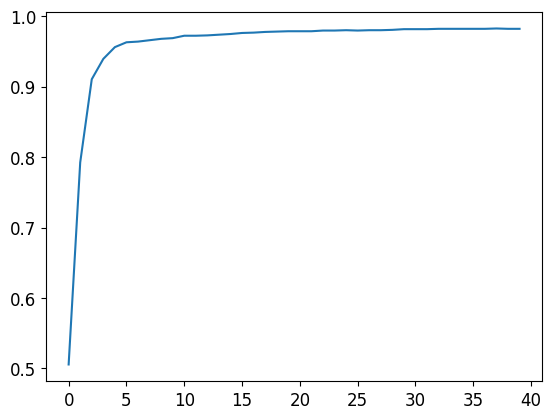

In [89]:
# plotting the accuracy training, the x-axis is the epoch number and the y-axis is the accuracy
plt.plot(L(learn.recorder.values).itemgot(2))

In [90]:
# let's try more layers with a pre trained model
dls = ImageDataLoaders.from_folder(path_to_mnist)
learn = vision_learner(dls, resnet18, pretrained=False,
    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.065239,0.017955,0.995584,00:10


See what we can do with fewer epochs and more layers ? That's impressive !